In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('../')

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from src.metrics import *
from src.models import * 
from src.concept_vectors import *
import csv
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as mtick
import matplotlib.colors as mcolors
import seaborn as sns
from ete3 import Tree
from collections import defaultdict
from src.hierarchy import *
import json 

## Impact of Metric

In [4]:
hierarchy_by_metric = {}
dataset = CUB_Dataset()
attributes = dataset.get_attributes()
for metric in ['euclidean','cosine','manhattan']:
    hierarchy_by_metric[metric] = {}

    for function,name in zip([load_label_vectors_simple,
    load_shapley_vectors_simple, 
    load_cem_vectors_simple,
    load_concept2vec_vectors_simple
    ],['label','shapley','cem','concept2vec']):
        hierarchy_by_metric[metric][name] = {}
        for seed in [43,44,45]:
            hierarchy_by_metric[metric][name][seed] = flat_distance_to_square(get_concept_distances(function,dataset,'',attributes,seed,metric=metric))

In [5]:
avg_pairwise_distance = {}
for name in ['label','shapley','cem','concept2vec']:
    avg_pairwise_distance[name] = {}
    for metric_1 in ['euclidean','cosine','manhattan']:
        avg_pairwise_distance[name][metric_1] = {}
        for metric_2 in ['euclidean','cosine','manhattan']:
            h1 = hierarchy_by_metric[metric_1][name]
            h2 = hierarchy_by_metric[metric_2][name]
            results = [embedding_distance(h1[seed],h2[seed],k=3) for seed in [43,44,45]]
            avg_pairwise_distance[name][metric_1][metric_2] = (np.mean(results),np.std(results))

In [8]:
json.dump(avg_pairwise_distance,open('results/extra_evaluation/metric_distances.json','w'))

In [9]:
hierarchy_object_by_metric = {}
dataset = CUB_Dataset()
attributes = dataset.get_attributes()
for metric in ['euclidean','cosine','manhattan']:
    hierarchy_object_by_metric[metric] = {}

    for function,name in zip([load_label_vectors_simple,
    load_shapley_vectors_simple, 
    load_cem_vectors_simple,
    load_concept2vec_vectors_simple
    ],['label','shapley','cem','concept2vec']):
        hierarchy_object_by_metric[metric][name] = {}
        for seed in [43,44,45]:
            hierarchy_object_by_metric[metric][name][seed] = create_hierarchy(create_ward_hierarchy,function,dataset,'',attributes,seed,metric=metric) 

### Investigate why this occurs

In [10]:
cosine_hierarchy = hierarchy_object_by_metric['cosine']['label'][43]
euclidean_hierarchy = hierarchy_object_by_metric['euclidean']['label'][43]

In [11]:
print(cosine_hierarchy)

                     ---- has_belly_color::brown
                ----|
                          ---- has_underparts_color::brown
                     ----|
                          ---- has_breast_color::brown


           ----|
                          ---- has_nape_color::brown
                     ----|
                               ---- has_forehead_color::brown
                          ----|
                               ---- has_crown_color::brown


                ----|
                               ---- has_upper_tail_color::brown
                          ----|
                               ---- has_under_tail_color::brown

                     ----|
                               ---- has_primary_color::brown
                          ----|
                                    ---- has_back_color::brown
                               ----|
                                         ---- has_wing_color::brown
                                    ----|
                     

In [12]:
print(euclidean_hierarchy)

                     ---- has_throat_color::white
                ----|
                          ---- has_breast_color::white
                     ----|
                               ---- has_underparts_color::white
                          ----|
                               ---- has_belly_color::white



           ----|
                               ---- has_upper_tail_color::grey
                          ----|
                               ---- has_under_tail_color::grey

                     ----|
                               ---- has_wing_color::grey
                          ----|
                                    ---- has_primary_color::grey
                               ----|
                                         ---- has_upperparts_color::grey
                                    ----|
                                         ---- has_back_color::grey




                ----|
                          ---- has_bill_length::about_the_same_as_head
               

In [13]:
top_k_euclidean = get_top_k_pairs(hierarchy_by_metric['euclidean']['label'][43],k=3)
top_k_cosine = get_top_k_pairs(hierarchy_by_metric['cosine']['label'][43],k=3)

top_k_euclidean = [(attributes[i[0]],attributes[i[1]]) for i in top_k_euclidean]
top_k_cosine = [(attributes[i[0]],attributes[i[1]]) for i in top_k_cosine]

In [14]:
all_distances = [np.mean([embedding_distance(hierarchy_by_metric['cosine']['label'][seed],hierarchy_by_metric['euclidean']['label'][seed],k=k) for seed in [43,44,45]]) for k in range(1,110)]

In [17]:
json.dump({
    'all_distances': all_distances, 
    'top_k_euclidean': top_k_euclidean, 
    'top_k_cosine': top_k_cosine, 
},open('results/extra_evaluation/distance_cosine_euclidean_top_k.json','w'))

In [18]:
percent_euclidean_agree = len([i for i in top_k_euclidean if i[0].split("::")[1] == i[1].split("::")[1]])/len(top_k_euclidean)
percent_cosine_agree = len([i for i in top_k_cosine if i[0].split("::")[1] == i[1].split("::")[1]])/len(top_k_euclidean)
percent_euclidean_agree,percent_cosine_agree

(0.7053571428571429, 0.7291666666666666)

In [19]:
all_top_k_euclidean = []
all_top_k_cosine = []

for seed in [43,44,45]:
    top_k_euclidean = get_top_k_pairs(hierarchy_by_metric['euclidean']['label'][seed],k=3)
    top_k_cosine = get_top_k_pairs(hierarchy_by_metric['cosine']['label'][seed],k=3)

    top_k_euclidean = [(attributes[i[0]],attributes[i[1]]) for i in top_k_euclidean]
    top_k_cosine = [(attributes[i[0]],attributes[i[1]]) for i in top_k_cosine]

    all_top_k_euclidean += top_k_euclidean
    all_top_k_cosine += top_k_cosine


percent_euclidean_agree = len([i for i in all_top_k_euclidean if i[0].split("::")[1] == i[1].split("::")[1]])/len(top_k_euclidean)
percent_cosine_agree = len([i for i in all_top_k_cosine if i[0].split("::")[1] == i[1].split("::")[1]])/len(top_k_euclidean)
percent_euclidean_agree/3, percent_cosine_agree/3

(0.7053571428571428, 0.7291666666666666)

## Impact of Distance (Zhang Sha Sha)

In [20]:
similarities = {
    'cosine': [],
    'euclidean': [],
}

In [21]:
for metric in ['euclidean','cosine']:
    for name in ['label','shapley','cem','concept2vec']:
        for name_2 in ['label','shapley','cem','concept2vec']:
            if name > name_2:
                h1 = hierarchy_object_by_metric[metric][name]
                h2 = hierarchy_object_by_metric[metric][name_2]

                our_distance = [embedding_distance(hierarchy_by_metric[metric][name][seed],hierarchy_by_metric[metric][name_2][seed],k=3) for seed in [43,44,45]]
                our_distance = (np.mean(our_distance),np.std(our_distance))

                zss_distance = [h1[seed].distance(h2[seed]) for seed in [43,44,45]]
                zss_distance = (np.mean(zss_distance),np.std(zss_distance))

                similarities[metric].append((our_distance[0],zss_distance[0]))

In [23]:
json.dump(similarities, open('results/extra_evaluation/similarity_to_zhang.json','w'))

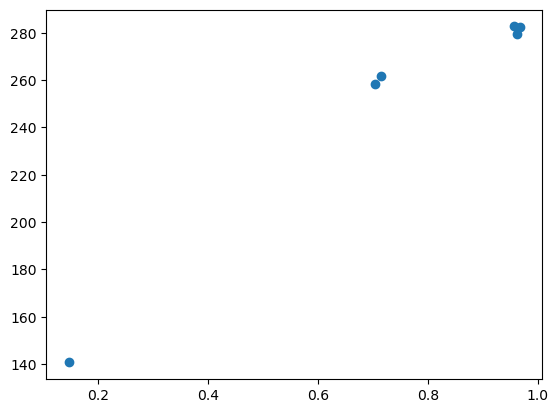

In [24]:
plt.scatter([i[0] for i in similarities['cosine']],[i[1] for i in similarities['cosine']])

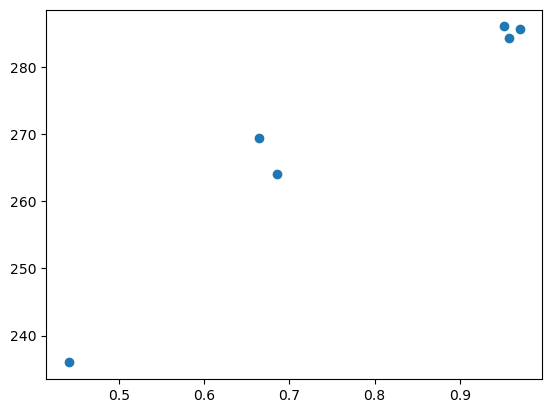

In [25]:
plt.scatter([i[0] for i in similarities['euclidean']],[i[1] for i in similarities['euclidean']])

## Impact of Ward vs. Max vs. Min

In [26]:
h1 = create_hierarchy(create_ward_hierarchy,load_label_vectors_simple,dataset,'',attributes,43) 
h2 = create_hierarchy(create_min_hierarchy,load_label_vectors_simple,dataset,'',attributes,43) 
h3 = create_hierarchy(create_max_hierarchy,load_label_vectors_simple,dataset,'',attributes,43) 

In [27]:
print(h1)

                     ---- has_throat_color::white
                ----|
                          ---- has_breast_color::white
                     ----|
                               ---- has_underparts_color::white
                          ----|
                               ---- has_belly_color::white



           ----|
                               ---- has_upper_tail_color::grey
                          ----|
                               ---- has_under_tail_color::grey

                     ----|
                               ---- has_wing_color::grey
                          ----|
                                    ---- has_primary_color::grey
                               ----|
                                         ---- has_upperparts_color::grey
                                    ----|
                                         ---- has_back_color::grey




                ----|
                          ---- has_bill_length::about_the_same_as_head
               

In [28]:
print(h2)

      ---- has_wing_shape::rounded-wings
 ----|
           ---- has_bill_color::black
      ----|
                     ---- has_size::small_(5_-_9_in)
                ----|
                          ---- has_bill_length::shorter_than_head
                     ----|
                          ---- has_shape::perching-like


           ----|
                     ---- has_bill_shape::all-purpose
                ----|
                               ---- has_back_pattern::solid
                          ----|
                                         ---- has_leg_color::black
                                    ----|
                                              ---- has_leg_color::grey
                                         ----|
                                                   ---- has_tail_shape::notched_tail
                                              ----|
                                                        ---- has_bill_length::about_the_same_as_head
                          

In [29]:
print(h3)

                ---- has_eye_color::black
           ----|
                     ---- has_breast_pattern::solid
                ----|
                     ---- has_belly_pattern::solid


      ----|
                ---- has_wing_shape::rounded-wings
           ----|
                     ---- has_bill_shape::all-purpose
                ----|
                          ---- has_size::small_(5_-_9_in)
                     ----|
                               ---- has_bill_length::shorter_than_head
                          ----|
                               ---- has_shape::perching-like





 ----|
                     ---- has_back_pattern::solid
                ----|
                          ---- has_tail_pattern::solid
                     ----|
                          ---- has_wing_pattern::solid


           ----|
                                    ---- has_wing_color::black
                               ----|
                                    ---- has_upperparts_color::black


In [30]:
h1 = create_hierarchy(create_ward_hierarchy,load_label_vectors_simple,MNIST_Dataset(),'',MNIST_Dataset().get_attributes(),43) 
h2 = create_hierarchy(create_min_hierarchy,load_label_vectors_simple,MNIST_Dataset(),'',MNIST_Dataset().get_attributes(),43) 
h3 = create_hierarchy(create_max_hierarchy,load_label_vectors_simple,MNIST_Dataset(),'',MNIST_Dataset().get_attributes(),43) 

In [31]:
print(h1)

      ---- spurious
 ----|
                ---- 1_color
           ----|
                ---- 1_number

      ----|
                     ---- 7_color
                ----|
                     ---- 7_number

           ----|
                          ---- 3_color
                     ----|
                          ---- 3_number

                ----|
                               ---- 2_color
                          ----|
                               ---- 2_number

                     ----|
                                    ---- 9_color
                               ----|
                                    ---- 9_number

                          ----|
                                         ---- 0_color
                                    ----|
                                         ---- 0_number

                               ----|
                                              ---- 6_color
                                         ----|
                                 

In [32]:
print(h2)

      ---- spurious
 ----|
                ---- 1_color
           ----|
                ---- 1_number

      ----|
                     ---- 7_color
                ----|
                     ---- 7_number

           ----|
                          ---- 3_color
                     ----|
                          ---- 3_number

                ----|
                               ---- 2_color
                          ----|
                               ---- 2_number

                     ----|
                                    ---- 9_color
                               ----|
                                    ---- 9_number

                          ----|
                                         ---- 0_color
                                    ----|
                                         ---- 0_number

                               ----|
                                              ---- 6_color
                                         ----|
                                 

In [33]:
print(h3)

      ---- spurious
 ----|
                ---- 1_color
           ----|
                ---- 1_number

      ----|
                     ---- 7_color
                ----|
                     ---- 7_number

           ----|
                          ---- 3_color
                     ----|
                          ---- 3_number

                ----|
                               ---- 2_color
                          ----|
                               ---- 2_number

                     ----|
                                    ---- 9_color
                               ----|
                                    ---- 9_number

                          ----|
                                         ---- 0_color
                                    ----|
                                         ---- 0_number

                               ----|
                                              ---- 6_color
                                         ----|
                                 

More Analysis in Baseline Hierarchies

## Similarity of Shapley and Label

In [34]:
hierarchy_by_dataset = defaultdict(lambda: defaultdict(dict))
for dataset_function,dataset_name in zip([CUB_Dataset, MNIST_Dataset, DSprites_Dataset, Chexpert_Dataset],['cub','mnist','dsprites','chexpert']):
    dataset = dataset_function()
    attributes = dataset.get_attributes()

    for function,name in zip([load_label_vectors_simple,
    load_shapley_vectors_simple, 
    load_cem_vectors_simple,
    load_concept2vec_vectors_simple
    ],['label','shapley','cem','concept2vec']):
        hierarchy_by_metric[metric][name] = {}
        for seed in [43,44,45]:
            hierarchy_by_dataset[dataset_name][name][seed] = flat_distance_to_square(get_concept_distances(function,dataset,'',attributes,seed))


In [35]:
distance_by_dataset = defaultdict(lambda: defaultdict(dict))

for dataset in ['cub','mnist','dsprites','chexpert']:
    for name in ['cem','shapley','label','concept2vec']:
        for name_2 in ['cem','shapley','label','concept2vec']:
            h1 = hierarchy_by_dataset[dataset][name]
            h2 = hierarchy_by_dataset[dataset][name_2]
            distance_by_dataset[dataset][name][name_2] = [embedding_distance(h1[seed],h2[seed],k=3) for seed in [43,44,45]]


In [36]:
distances_cub = np.array([[distance_by_dataset['cub'][i][j] for j in distance_by_dataset['cub'][i]] for i in distance_by_dataset['cub']])
distances_cub = np.mean(distances_cub,axis=2)

In [37]:
labels = ['cem','shapley','label','concept2vec']

In [39]:
json.dump(distances_cub.tolist(), open('results/extra_evaluation/distance_between_hierarchies.json','w'))

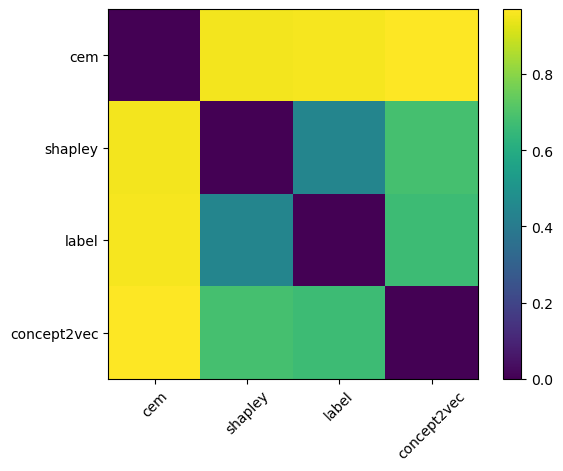

In [40]:
plt.imshow(distances_cub, cmap='viridis', interpolation='nearest')

# Add labels and ticks
plt.xticks(np.arange(len(labels)), labels, rotation=45)
plt.yticks(np.arange(len(labels)), labels)
plt.colorbar()

# Show the plot
plt.show()

## Why does CEM do poorly?

In [41]:
cem_hierarchy = hierarchy_object_by_metric['euclidean']['cem'][43]
print(cem_hierarchy)

                ---- has_belly_color::grey
           ----|
                     ---- has_upperparts_color::yellow
                ----|
                          ---- has_underparts_color::yellow
                     ----|
                          ---- has_upper_tail_color::white



      ----|
                ---- has_back_color::yellow
           ----|
                          ---- has_wing_pattern::striped
                     ----|
                               ---- has_primary_color::yellow
                          ----|
                                         ---- has_forehead_color::white
                                    ----|
                                              ---- has_wing_pattern::multi-colored
                                         ----|
                                                   ---- has_primary_color::brown
                                              ----|
                                                        ---- has_back_color::white
   

In [48]:
dataset = CUB_Dataset()
attributes = dataset.get_attributes()

In [49]:
top_k_cem = get_top_k_pairs(hierarchy_by_metric['euclidean']['cem'][43],k=3)
top_k_cem = [(attributes[i[0]],attributes[i[1]]) for i in top_k_cem]
len([i for i in top_k_cem if i[0].split("::")[1] == i[1].split("::")[1]])/len(top_k_cem)

0.10714285714285714

In [50]:
json.dump(top_k_cem,open('results/extra_evaluation/top_k_cem.json','w'))

In [51]:
len([i for i in top_k_cem if i[0].split("::")[0] == i[1].split("::")[0]])/len(top_k_cem)

0.044642857142857144

In [52]:
top_k_cem_44 = get_top_k_pairs(hierarchy_by_metric['euclidean']['cem'][44],k=3)
top_k_cem_44 = [(attributes[i[0]],attributes[i[1]]) for i in top_k_cem_44]
len(set(top_k_cem_44).intersection(set(top_k_cem)))/len(top_k_cem_44)

0.03273809523809524

## Comparison with Known Hierarchy

### In MNIST

In [53]:
mnist = MNIST_Dataset()
mnist_attributes = mnist.get_attributes()

In [54]:
baseline_distances = np.zeros((len(mnist_attributes),len(mnist_attributes)))

In [55]:
for i, attribute_1 in enumerate(mnist_attributes):
    for j, attribute_2 in enumerate(mnist_attributes):
        baseline_distances[i][j] = (1-int(attribute_1[0] == attribute_2[0]))

In [56]:
distance_by_method_mnist = {}
for function,name in zip([load_label_vectors_simple,
    load_shapley_vectors_simple, 
    load_cem_vectors_simple,
    load_concept2vec_vectors_simple
    ],['label','shapley','cem','concept2vec']):
    h_list = [flat_distance_to_square(get_concept_distances(function,mnist,'',mnist_attributes,seed)) for seed in [43,44,45]]
    distance_by_method_mnist[name] = [embedding_distance(h,baseline_distances,k=1) for h in h_list]
    distance_by_method_mnist[name] = (np.mean(distance_by_method_mnist[name]),np.std(distance_by_method_mnist[name]))

In [57]:
json.dump(distance_by_method_mnist,open('results/extra_evaluation/distance_mnist.json','w'))

### In CUB

In [58]:
cub = CUB_Dataset()
cub_attributes = cub.get_attributes()

In [59]:
baseline_distances_color = np.zeros((len(cub_attributes),len(cub_attributes)))

In [60]:
for i, attribute_1 in enumerate(cub_attributes):
    for j, attribute_2 in enumerate(cub_attributes):
        baseline_distances_color[i][j] = (1-int(attribute_1.split("::")[1] == attribute_2.split("::")[1])) + abs(random.random()/100)*int(attribute_1 != attribute_2)

In [61]:
distance_by_method_cub = {}
for function,name in zip([load_label_vectors_simple,
    load_shapley_vectors_simple, 
    load_cem_vectors_simple,
    load_concept2vec_vectors_simple
    ],['label','shapley','cem','concept2vec']):
    h_list = [flat_distance_to_square(get_concept_distances(function,cub,'',cub_attributes,seed)) for seed in [43,44,45]]
    distance_by_method_cub[name] = [embedding_distance(h,baseline_distances_color,k=3) for h in h_list]
    distance_by_method_cub[name] = (np.mean(distance_by_method_cub[name]),np.std(distance_by_method_cub[name]))

In [62]:
json.dump(distance_by_method_cub,open('results/extra_evaluation/distance_cub_second_part.json','w'))

In [63]:
distance_by_method_cub

{'label': (0.8065476190476191, 0.0),
 'shapley': (0.7916666666666666, 0.0),
 'cem': (0.9593253968253969, 0.00505855110475478),
 'concept2vec': (0.8273809523809524, 0.01928791874526147)}

In [64]:
top_pairs = get_top_k_pairs(baseline_distances_color,k=3)
top_pairs = [(cub_attributes[i[0]],cub_attributes[i[1]]) for i in top_pairs]

In [65]:
our_top_pairs = get_top_k_pairs(flat_distance_to_square(get_concept_distances(load_label_vectors_simple,cub,'',cub_attributes,43)))

In [66]:
our_top_pairs = [(cub_attributes[i[0]],cub_attributes[i[1]]) for i in our_top_pairs]

In [67]:
top_pairs[99:102], our_top_pairs[99:102] 

([('has_upper_tail_color::grey', 'has_leg_color::grey'),
  ('has_upper_tail_color::grey', 'has_forehead_color::grey'),
  ('has_upper_tail_color::grey', 'has_throat_color::grey')],
 [('has_upper_tail_color::grey', 'has_under_tail_color::grey'),
  ('has_upper_tail_color::grey', 'has_wing_color::grey'),
  ('has_upper_tail_color::grey', 'has_upperparts_color::grey')])

In [68]:
baseline_distances_attribute = np.zeros((len(cub_attributes),len(cub_attributes)))

In [69]:
for i, attribute_1 in enumerate(cub_attributes):
    for j, attribute_2 in enumerate(cub_attributes):
        baseline_distances_attribute[i][j] = (1-int(attribute_1.split("::")[0] == attribute_2.split("::")[0])) + abs(random.random()/100)*int(attribute_1 != attribute_2)

In [70]:
distance_by_method_cub = {}
for function,name in zip([load_label_vectors_simple,
    load_shapley_vectors_simple, 
    load_cem_vectors_simple,
    load_concept2vec_vectors_simple
    ],['label','shapley','cem','concept2vec']):
    h_list = [flat_distance_to_square(get_concept_distances(function,cub,'',cub_attributes,seed)) for seed in [43,44,45]]
    distance_by_method_cub[name] = [embedding_distance(h,baseline_distances_attribute,k=3) for h in h_list]
    distance_by_method_cub[name] = (np.mean(distance_by_method_cub[name]),np.std(distance_by_method_cub[name]))

In [71]:
json.dump(distance_by_method_cub,open('results/extra_evaluation/distance_cub_first_part.json','w'))